In [ ]:

import numpy as np
import numpy.linalg as LA
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats as st
import scipy.optimize as sco
import bs4 as bs
import requests
import yfinance as yf
import datetime

def VaR(df,a=0.01,hist_interpolation='linear'):
    """For the given DataFrame of returns function calculates VaR by three methods.
    Paramters are:
    -df: DataFrame or Series of returns.
    -a: optional. It is probability that loss can be higher than VaR.
    -hist_interpolation: sets estimator of quantile's position in historical VaR. For more info see help for Pandas quantile"""
    if any([isinstance(df,i) for i in [pd.Series, pd.DataFrame]])==False:
        return print("Wrong input! Please insert data as pd.Series or pd.DataFrame object")
    elif isinstance(df,pd.Series):
        df=df.to_frame()
    else:
        pass
    dfN=pd.DataFrame(index=['Historical','Gaussian','Cornish Fisher'],columns=df.columns)
    for i in range(df.shape[1]):
        r=df.iloc[:,i]
        z=st.norm().ppf(a)
        zk = (z +(z**2 - 1)*r.skew()/6 +(z**3 -3*z)*(r.kurtosis())/24 -(2*z**3 - 5*z)*(r.skew()**2)/36)
        dfN.iloc[0,i]=np.abs(r.quantile(a, interpolation=hist_interpolation))
        dfN.iloc[1,i]= -(r.mean() + z*r.std())
        dfN.iloc[2,i]= -(r.mean() + zk*r.std())
    return dfN





In [ ]:

def log_normal_var(returns, a=0.01, hist_interpolation='linear'):
    """Calculate VaR using the log-normal premise of returns.

    Parameters:
    - returns: DataFrame or Series of log-returns.
    - a: Optional. Probability that loss can be higher than VaR.
    - hist_interpolation: Sets estimator of quantile's position in historical VaR.
      For more info, see help for Pandas quantile.
    """
    if not isinstance(returns, (pd.Series, pd.DataFrame)):
        return print("Wrong input! Please insert data as pd.Series or pd.DataFrame object")

    if isinstance(returns, pd.Series):
        returns = returns.to_frame()

    df_var = pd.DataFrame(index=['Historical', 'Gaussian', 'Cornish Fisher'], columns=returns.columns)

    for column in returns.columns:
        log_returns = np.log(1 + returns[column])

        z = st.norm.ppf(a)
        zk = (z + (z**2 - 1) * log_returns.skew() / 6 +
              (z**3 - 3 * z) * (log_returns.kurtosis()) / 24 -
              (2 * z**3 - 5 * z) * (log_returns.skew()**2) / 36)

        df_var.loc['Historical', column] = np.exp(log_returns.quantile(a, interpolation=hist_interpolation)) - 1
        df_var.loc['Gaussian', column] = -(log_returns.mean() + z * log_returns.std())
        df_var.loc['Cornish Fisher', column] = -(log_returns.mean() + zk * log_returns.std())

    return df_var


In [ ]:
def hist(df,CDF=False):
    """For the given DataFrame or Series of returns function plot histogram along with appropriate normal curve for each colummn.
    Parameters are:
    - df: DataFrame or Series of returns.
    - CDF: If True is given returns comparison of empirical and theoretical CDF, while if False is given returns comparison of
    theoretical and empirical PDF"""
    if str(type(df))!="<class 'pandas.core.frame.DataFrame'>" and str(type(df))!="<class 'pandas.core.series.Series'>":
        return print("Wrong input! Please insert data as Pandas' Series or DataFrame object")
    elif str(type(df))=="<class 'pandas.core.series.Series'>":
        df=df.to_frame()
    else:
        pass
    n=df.shape[1]
    if n==1:
        Row=1
        fig = make_subplots(rows=1, cols=1)
    elif n%2==0:
        Row=int(n/2)
        fig = make_subplots(rows=Row, cols=2,subplot_titles=df.columns,shared_yaxes=True,specs=[[{}, {}]]*Row)
    else:
        Row=int((n-1)/2)+1
        fig = make_subplots(rows=Row, cols=2,subplot_titles=df.columns,
                            shared_yaxes=True,specs=[[{}, {}]]*(Row-1) +[[{"colspan": 2}, None]])
    l_Row=[item for sublist in [[i,i] for i in range(1,Row+1)] for item in sublist]

    for i in range(n):
        r=df.iloc[:,i]
        x_list=(np.linspace(min(r),max(r),100) if CDF else np.linspace(r.mean()-3*r.std(),r.mean()+3*r.std(),100))
        y_list=(st.norm.cdf(x_list,r.mean(),r.std()) if CDF else st.norm.pdf(x_list,r.mean(),r.std())/100)
        fig.add_trace(go.Histogram(x=r, marker=dict(color='Orange',line=dict(width=2,color='black')),
            histnorm='probability',cumulative=dict(enabled=CDF)),row=l_Row[i],col=(2 if (i+1)%2==0 else 1))
        fig.add_trace(go.Scatter(x=x_list,y=y_list,line_color='DarkGreen',fill='tozeroy'),
                      row=l_Row[i],col=(2 if (i+1)%2==0 else 1))
        fig.update_xaxes(zerolinecolor='black',row=l_Row[i],col=(2 if (i+1)%2==0 else 1))
        fig.update_yaxes(zerolinecolor='black',row=l_Row[i],col=(2 if (i+1)%2==0 else 1))
    fig.update_layout(title=dict(text='Histograms and normal curve',font=dict(size=30),x=0.5,y=0.95),showlegend=False)

    return fig.show()

In [ ]:
def box(df):
    """For the given DataFrame of returns function plot box plot for each colummn.
    Function has only one required parameter - DataFrame or Series of returns."""
    if str(type(df))!="<class 'pandas.core.frame.DataFrame'>" and str(type(df))!="<class 'pandas.core.series.Series'>":
        return print("Wrong input! Please insert data as Pandas' Series or DataFrame object")
    elif str(type(df))=="<class 'pandas.core.series.Series'>":
        df=df.to_frame()
    else:
        pass
    fig=go.Figure()
    for i in range(df.shape[1]):
        r=df.iloc[:,i]
        IQR=r.quantile(q=0.75)-r.quantile(q=0.25)
        extremes=r[(r>=r.quantile(q=0.75)+3*IQR) | (r<=r.quantile(q=0.25)-3*IQR)].values
        fig.add_trace(go.Box(y=r,name=df.columns[i]))
        fig.add_trace(go.Scatter(x=[df.columns[i]]*len(extremes),y=extremes,
                                 mode='markers',marker=dict(color='black',symbol='star',size=15),showlegend=False))
    fig.update_layout(title=dict(text='Box plot of returns',font=dict(size=30),x=0.5,y=0.95),width=900,height=650)
    return fig.show()

In [ ]:
def cvar_historic(r, a=0.01,hist_interpolation='linear'):
    """Computes the Conditional VaR of Series or DataFrame"""
    if isinstance(r, pd.Series):
        is_beyond = r <= -VaR(r, a=a,hist_interpolation=hist_interpolation).iloc[0].values[0]
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, a=a)
    else:
        raise TypeError("Expected r to be a pd.Series or pd.DataFrame")

In [ ]:
EndDate=datetime.datetime.now().strftime('%Y-%m-%d')
StartDate=(datetime.datetime.now()-datetime.timedelta(days=365)).strftime('%Y-%m-%d')
data=yf.download("TSLA",start=StartDate,end=EndDate)
returns=data['Close'].pct_change().dropna()
print(returns)

[*********************100%%**********************]  1 of 1 completed

Date
2023-01-24    0.000974
2023-01-25    0.003753
2023-01-26    0.109673
2023-01-27    0.110002
2023-01-30   -0.063182
                ...   
2024-01-16    0.004660
2024-01-17   -0.019826
2024-01-18   -0.017026
2024-01-19    0.001463
2024-01-22   -0.015976
Name: Close, Length: 250, dtype: float64


In [ ]:
VaR(returns)

,Close
Historical,0.078391
Gaussian,0.072788
Cornish Fisher,0.076744


In [ ]:
hist(returns)

In [ ]:
box(returns)

<Axes: xlabel='Date'>

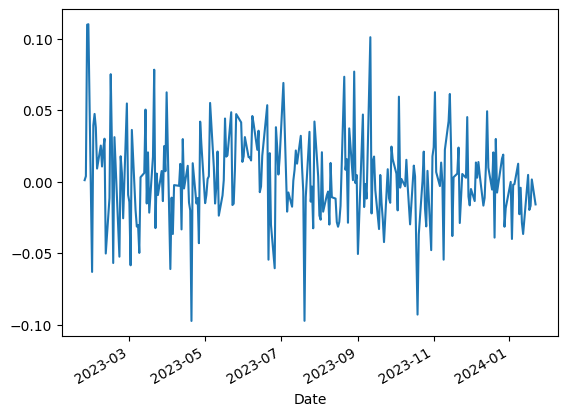

In [ ]:
returns.plot()

In [ ]:
cvar_historic(returns)

0.09594382757112045

In [ ]:
log_normal_var(returns)

,Close
Historical,-0.078511
Gaussian,0.07304
Cornish Fisher,0.080875
